# 1. Get Reviews from Amazon

## 1.1 Set up Beautiful Soup and Requests

In [2]:
import requests
from bs4 import BeautifulSoup
import re

In [6]:
# Set up hedder to Scrape Amazon
HEADERS = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
            AppleWebKit/537.36 (KHTML, like Gecko) \
            Chrome/90.0.4430.212 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})

In [7]:
url = r'https://www.amazon.de/M%C3%9CHLE-10er-Rasierklingen-traditionelle-Sicherheitsrasierer/product-reviews/B00TQLHOTO/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'

In [8]:
# Get raw html data with Requests
html = requests.get(url, headers=HEADERS)

In [9]:
# Check html Status code (200 = ok)
html.status_code

200

## 1.2 Convert Text to Soup

In [10]:
# Create Soup object from html Data
soup = BeautifulSoup(html.text, 'html.parser')

In [11]:
# Find user reviews in the data
results = soup.find_all('span', {'data-hook': 'review-body'})
print(results[0].text)


Top Produkt mit einer sehr gute Qualität



In [12]:
len(results)

10

## 1.3 Scraping Multible Pages

In [14]:
# Construct list of links to scrape multiple pages
links = []
for x in range(14):
    links.append(f'https://www.amazon.de/M%C3%9CHLE-10er-Rasierklingen-traditionelle-Sicherheitsrasierer/product-reviews/B00TQLHOTO/ref=cm_cr_getr_d_paging_btm_prev_1?ie=UTF8&reviewerType=all_reviews&pageNumber={x}')

In [15]:
# Scrape all links in the constructed list
reviews = []
for link in links:
    html = requests.get(link, headers=HEADERS)
    if html.status_code == 200:
        # HTML response was sucssesfull
        soup = BeautifulSoup(html.text, 'html.parser')
        results = soup.find_all('span', {'data-hook': 'review-body'})
        for review in results:
            reviews.append(review.text.replace('\n', ''))
    else:
        # HTML response was unsuccsessfull
        print('[BAD HTML RESPONSE] Response Code =', html.status_code)            

In [16]:
len(reviews)

139

# 2. Translate Reviews

## 2.1 Determine Language of Reviews

In [171]:
!pip install detectlanguage pandas

  Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl (10.4 MB)
  Using cached numpy-1.24.1-cp310-cp310-win_amd64.whl (14.8 MB)
  Using cached pytz-2022.7.1-py2.py3-none-any.whl (499 kB)


In [3]:
import detectlanguage
import pandas as pd

In [18]:
# Setup the API key
detectlanguage.configuration.api_key = "API_KEY"

In [19]:
# Test API to detect languages
review = reviews[120]
language = detectlanguage.detect(review)
print(review, '|' ,language[0]['language'])

Pacco arrivato per tempo, grazie alla puntualità di amazon. Prodotto valido per un ottimo compromesso di affilatura e durata. Utilizzato sia con un rasoio di sicurezza Merkur Future 700 che con un rasoio closed comb di muhle. Consigliato | it


In [21]:
# Detect languges of all reviews
languages = []
for review in reviews:
    language = detectlanguage.detect(review)
    languages.append(language[0]['language'])

In [22]:
# Construct Data frame containing review and Language
df = pd.DataFrame({'Review': reviews, 'Language': languages})

In [179]:
df['Language'].value_counts()

de    95
it    17
fr    13
es     8
en     6
Name: Language, dtype: int64

In [23]:
# Save df as csv
df.to_csv('Data/Reviews.csv')

## 2.2 Translate reviews

In [31]:
!pip install deepl

In [67]:
import deepl

In [68]:
# Read csv
df = pd.read_csv('Data/Reviews.csv', index_col=0)

In [69]:
deepl_auth_key = 'API-KEY'
translator = deepl.Translator(deepl_auth_key)

In [70]:
review = df.iloc[0,0]
language = df.iloc[0,1]
translated = translator.translate_text(review, target_lang='en-gb')
print(review, '|' ,translated)

Top Produkt mit einer sehr gute Qualität | Top product with a very good quality


In [71]:
# Translate reviews
translations = []
for row in df.iterrows():
    review = row[1][0]
    language = row[1][1]
    if language == 'en':
        tranlation = review
    else:
        translation = translator.translate_text(review, target_lang='en-gb', source_lang=language)
        
    translations.append(translation)

In [72]:
# Add Translation to dataframe
df['Translated'] = translations

In [73]:
df.to_csv('Data/Reviews_Translated.csv')

# 3. Analysing the Reviews

## 3.1 Callculating Text Metrics

In [4]:
df = pd.read_csv('Data/Reviews_Translated.csv', index_col=0)

In [5]:
df.head()

,Review,Language,Translated
0,Top Produkt mit einer sehr gute Qualität,de,Top product with a very good quality
1,"Hallo,Ich hab das Produkt für meinen Rasierhob...",de,"Hello,I bought this product for my razor. The ..."
2,Da ich mich länger mit Rasiermesser und Rasier...,de,Since I've been shaving with a razor and strai...
3,Klingen laufen gut und sind scharf für 2 Rasur...,de,"Blades run well and are sharp for 2 shaves, th..."
4,Bei mir halten die mindestens 10 Mal wobei die...,de,"For me, they last at least 10 times, whereas t..."


In [6]:
df['Word_Count'] = df['Translated'].apply(lambda x: len(str(x).split()))
df['Char_Count'] = df['Translated'].str.len()

In [7]:
df[df['Word_Count'] == 113]['Translated'][8]

"We are beginners with the razor and are now trying out the blades from various manufacturers. I, a woman, am completely satisfied with the blades. I use them with a little shaving foam for all parts of the body. They are very sharp and don't dull quickly. The packaging is also good, you can always slide out a single blade. My boyfriend also thinks they are great and definitely better than those from the cheap manufacturers, but he is a bit demanding. He gets a bit twitchy when shaving his beard, so he's looking a bit further. All in all, it's great quality, but for the price, just try it out for yourself."

In [8]:
df[df['Word_Count'] == 1]

,Review,Language,Translated,Word_Count,Char_Count
59,Perfekt,de,Perfect,1,7
70,Qualität,de,Quality,1,7
71,zufrieden!,de,satisfied!,1,10
110,Perfetto,it,Perfect,1,7


## 3.2 Counting Stopwords

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leonr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stop_words = stopwords.words('english')

In [11]:
df['Stop-Words'] = df['Translated'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

In [12]:
df.head()

,Review,Language,Translated,Word_Count,Char_Count,Stop-Words
0,Top Produkt mit einer sehr gute Qualität,de,Top product with a very good quality,7,36,3
1,"Hallo,Ich hab das Produkt für meinen Rasierhob...",de,"Hello,I bought this product for my razor. The ...",107,635,44
2,Da ich mich länger mit Rasiermesser und Rasier...,de,Since I've been shaving with a razor and strai...,102,554,45
3,Klingen laufen gut und sind scharf für 2 Rasur...,de,"Blades run well and are sharp for 2 shaves, th...",22,183,9
4,Bei mir halten die mindestens 10 Mal wobei die...,de,"For me, they last at least 10 times, whereas t...",20,98,7


# 4. Preprocessing

## 4.1 Lowercase all Words

In [14]:
df.columns

Index(['Review', 'Language', 'Translated', 'Word_Count', 'Char_Count',
       'Stop-Words'],
      dtype='object')

In [15]:
df['Translated_Lower'] = df['Translated'].str.lower()

In [16]:
df.head()

,Review,Language,Translated,Word_Count,Char_Count,Stop-Words,Translated_Lower
0,Top Produkt mit einer sehr gute Qualität,de,Top product with a very good quality,7,36,3,top product with a very good quality
1,"Hallo,Ich hab das Produkt für meinen Rasierhob...",de,"Hello,I bought this product for my razor. The ...",107,635,44,"hello,i bought this product for my razor. the ..."
2,Da ich mich länger mit Rasiermesser und Rasier...,de,Since I've been shaving with a razor and strai...,102,554,45,since i've been shaving with a razor and strai...
3,Klingen laufen gut und sind scharf für 2 Rasur...,de,"Blades run well and are sharp for 2 shaves, th...",22,183,9,"blades run well and are sharp for 2 shaves, th..."
4,Bei mir halten die mindestens 10 Mal wobei die...,de,"For me, they last at least 10 times, whereas t...",20,98,7,"for me, they last at least 10 times, whereas t..."


## 4.2 Stripping Punctuation

In [17]:
df['Translated_Nopunc'] = df['Translated_Lower'].str.replace('[^\w\s]','')

C:\Users\leonr\AppData\Local\Temp\ipykernel_17264\420278567.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Translated_Nopunc'] = df['Translated_Lower'].str.replace('[^\w\s]','')


In [18]:
df.head()

,Review,Language,Translated,Word_Count,Char_Count,Stop-Words,Translated_Lower,Translated_Nopunc
0,Top Produkt mit einer sehr gute Qualität,de,Top product with a very good quality,7,36,3,top product with a very good quality,top product with a very good quality
1,"Hallo,Ich hab das Produkt für meinen Rasierhob...",de,"Hello,I bought this product for my razor. The ...",107,635,44,"hello,i bought this product for my razor. the ...",helloi bought this product for my razor the bl...
2,Da ich mich länger mit Rasiermesser und Rasier...,de,Since I've been shaving with a razor and strai...,102,554,45,since i've been shaving with a razor and strai...,since ive been shaving with a razor and straig...
3,Klingen laufen gut und sind scharf für 2 Rasur...,de,"Blades run well and are sharp for 2 shaves, th...",22,183,9,"blades run well and are sharp for 2 shaves, th...",blades run well and are sharp for 2 shaves the...
4,Bei mir halten die mindestens 10 Mal wobei die...,de,"For me, they last at least 10 times, whereas t...",20,98,7,"for me, they last at least 10 times, whereas t...",for me they last at least 10 times whereas the...


## 4.3 Removing Stopwords

In [21]:
df['Translated_Nostop'] = df['Translated_Nopunc'].apply(
    lambda x: " ".join(word for word in x.split() if word not in stop_words))

In [22]:
df.head()

,Review,Language,Translated,Word_Count,Char_Count,Stop-Words,Translated_Lower,Translated_Nopunc,Translated_Nostop
0,Top Produkt mit einer sehr gute Qualität,de,Top product with a very good quality,7,36,3,top product with a very good quality,top product with a very good quality,top product good quality
1,"Hallo,Ich hab das Produkt für meinen Rasierhob...",de,"Hello,I bought this product for my razor. The ...",107,635,44,"hello,i bought this product for my razor. the ...",helloi bought this product for my razor the bl...,helloi bought product razor blades make shavin...
2,Da ich mich länger mit Rasiermesser und Rasier...,de,Since I've been shaving with a razor and strai...,102,554,45,since i've been shaving with a razor and strai...,since ive been shaving with a razor and straig...,since ive shaving razor straight razor long ti...
3,Klingen laufen gut und sind scharf für 2 Rasur...,de,"Blades run well and are sharp for 2 shaves, th...",22,183,9,"blades run well and are sharp for 2 shaves, th...",blades run well and are sharp for 2 shaves the...,blades run well sharp 2 shaves gets tightother...
4,Bei mir halten die mindestens 10 Mal wobei die...,de,"For me, they last at least 10 times, whereas t...",20,98,7,"for me, they last at least 10 times, whereas t...",for me they last at least 10 times whereas the...,last least 10 times whereas brands g w last 3 ...


## 4.4 Visualising Common Words

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt

In [29]:
freq_words = pd.Series(" ".join(df['Translated_Nostop']).split()).value_counts().reset_index()

In [30]:
freq_words.columns = ['Words', 'Frequencies']

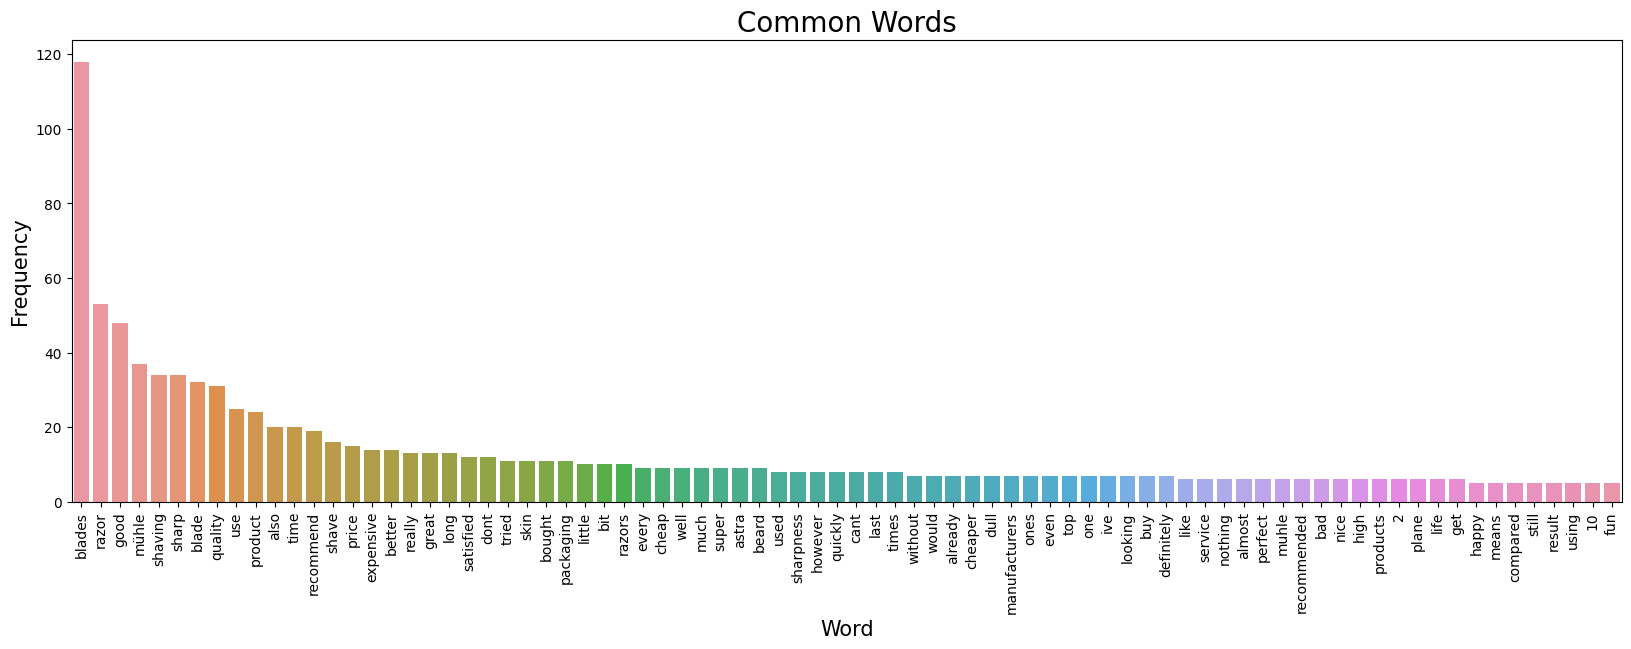

In [33]:
plt.figure(figsize=(20,6))
plt.title('Common Words', fontsize=20)
sns.barplot(x='Words', y='Frequencies', data=freq_words[:80])
plt.xticks(rotation=90)
plt.xlabel('Word', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

In [34]:
other_stopwords = ['mühle', 'one', 'ive', 'muhle', '2', '10']

In [36]:
df['Translated_Noother'] = df['Translated_Nostop'].apply(
    lambda x: " ".join(word for word in x.split() if word not in other_stopwords))

In [37]:
df.head()

,Review,Language,Translated,Word_Count,Char_Count,Stop-Words,Translated_Lower,Translated_Nopunc,Translated_Nostop,Translated_Noother
0,Top Produkt mit einer sehr gute Qualität,de,Top product with a very good quality,7,36,3,top product with a very good quality,top product with a very good quality,top product good quality,top product good quality
1,"Hallo,Ich hab das Produkt für meinen Rasierhob...",de,"Hello,I bought this product for my razor. The ...",107,635,44,"hello,i bought this product for my razor. the ...",helloi bought this product for my razor the bl...,helloi bought product razor blades make shavin...,helloi bought product razor blades make shavin...
2,Da ich mich länger mit Rasiermesser und Rasier...,de,Since I've been shaving with a razor and strai...,102,554,45,since i've been shaving with a razor and strai...,since ive been shaving with a razor and straig...,since ive shaving razor straight razor long ti...,since shaving razor straight razor long time a...
3,Klingen laufen gut und sind scharf für 2 Rasur...,de,"Blades run well and are sharp for 2 shaves, th...",22,183,9,"blades run well and are sharp for 2 shaves, th...",blades run well and are sharp for 2 shaves the...,blades run well sharp 2 shaves gets tightother...,blades run well sharp shaves gets tightotherwi...
4,Bei mir halten die mindestens 10 Mal wobei die...,de,"For me, they last at least 10 times, whereas t...",20,98,7,"for me, they last at least 10 times, whereas t...",for me they last at least 10 times whereas the...,last least 10 times whereas brands g w last 3 ...,last least times whereas brands g w last 3 times


In [39]:
freq_words = pd.Series(" ".join(df['Translated_Noother']).split()).value_counts().reset_index()

In [41]:
freq_words.columns = ['Words', 'Frequencies']

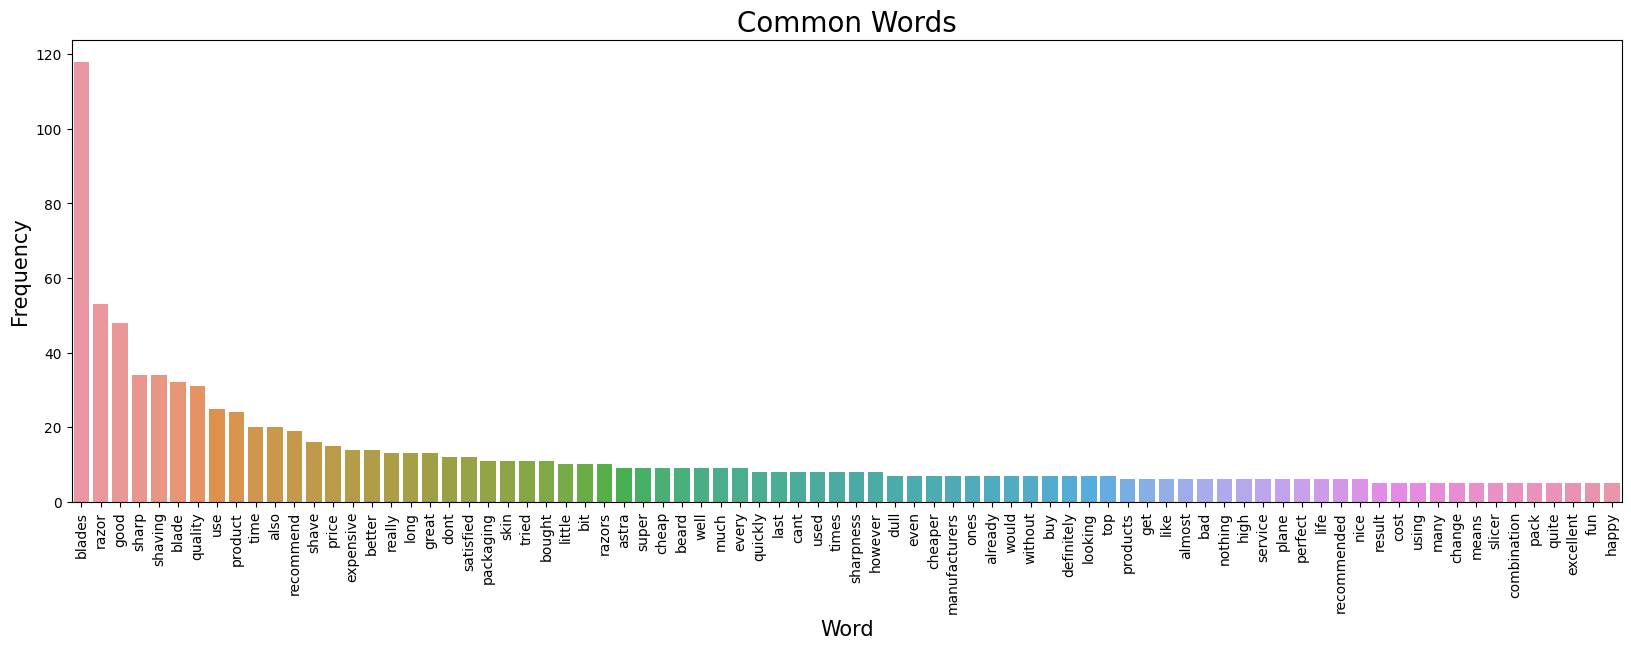

In [42]:
plt.figure(figsize=(20,6))
plt.title('Common Words', fontsize=20)
sns.barplot(x='Words', y='Frequencies', data=freq_words[:80])
plt.xticks(rotation=90)
plt.xlabel('Word', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

## 4.5 Lemmatize Reviews

In [43]:
from textblob import Word
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leonr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\leonr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [48]:
df['Cleaned_Review'] = df['Translated_Noother'].apply(
    lambda x: " ".join(Word(word).lemmatize() for word in x.split()))

In [52]:
df.head()

,Review,Language,Translated,Word_Count,Char_Count,Stop-Words,Translated_Lower,Translated_Nopunc,Translated_Nostop,Translated_Noother,CLeaned_Review,Cleaned_Review
0,Top Produkt mit einer sehr gute Qualität,de,Top product with a very good quality,7,36,3,top product with a very good quality,top product with a very good quality,top product good quality,top product good quality,top product good quality,top product good quality
1,"Hallo,Ich hab das Produkt für meinen Rasierhob...",de,"Hello,I bought this product for my razor. The ...",107,635,44,"hello,i bought this product for my razor. the ...",helloi bought this product for my razor the bl...,helloi bought product razor blades make shavin...,helloi bought product razor blades make shavin...,helloi bought product razor blade make shaving...,helloi bought product razor blade make shaving...
2,Da ich mich länger mit Rasiermesser und Rasier...,de,Since I've been shaving with a razor and strai...,102,554,45,since i've been shaving with a razor and strai...,since ive been shaving with a razor and straig...,since ive shaving razor straight razor long ti...,since shaving razor straight razor long time a...,since shaving razor straight razor long time a...,since shaving razor straight razor long time a...
3,Klingen laufen gut und sind scharf für 2 Rasur...,de,"Blades run well and are sharp for 2 shaves, th...",22,183,9,"blades run well and are sharp for 2 shaves, th...",blades run well and are sharp for 2 shaves the...,blades run well sharp 2 shaves gets tightother...,blades run well sharp shaves gets tightotherwi...,blade run well sharp shave get tightotherwise ...,blade run well sharp shave get tightotherwise ...
4,Bei mir halten die mindestens 10 Mal wobei die...,de,"For me, they last at least 10 times, whereas t...",20,98,7,"for me, they last at least 10 times, whereas t...",for me they last at least 10 times whereas the...,last least 10 times whereas brands g w last 3 ...,last least times whereas brands g w last 3 times,last least time whereas brand g w last 3 time,last least time whereas brand g w last 3 time


# 5. Sentiment Analysis

In [46]:
from textblob import TextBlob

In [53]:
df['Polarity'] = df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment[0])
df['Subjectivity'] = df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment[1])

In [54]:
filtered_df = df[['Translated', 'Polarity', 'Subjectivity']]

In [55]:
filtered_df.head()

,Translated,Polarity,Subjectivity
0,Top product with a very good quality,0.600000,0.550000
1,"Hello,I bought this product for my razor. The ...",0.094444,0.576389
2,Since I've been shaving with a razor and strai...,0.195192,0.529808
3,"Blades run well and are sharp for 2 shaves, th...",-0.062500,0.375000
4,"For me, they last at least 10 times, whereas t...",-0.100000,0.177778


In [56]:
filtered_df['Polarity'].max()

1.0

In [63]:
print(filtered_df[filtered_df['Polarity']==1].iloc[3]['Translated'])

Excellent quality.


In [64]:
filtered_df['Polarity'].min()

-0.6999999999999998

In [72]:
filtered_df[filtered_df['Polarity']<=-0.5].iloc[2]['Translated']

'The photo is deceptive! There are 10 blades!!This is very unfair!'

In [73]:
df.to_csv('Data/Amazon-Sentiment.csv')